In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [45]:
train = pd.read_csv('trainMA.csv')
test = pd.read_csv('testMA.csv')


In [46]:
train = train.rename(columns={'Unnamed: 0': 'date_forecast'})
test = test.rename(columns={'Unnamed: 0': 'date_forecast'})

In [47]:
train.set_index('date_forecast', inplace=True)
test.set_index('date_forecast', inplace=True)
train.index = pd.to_datetime(train.index)
#test = test.drop(columns = ['date_calc'])

In [48]:
columns_only_in_df2 = train.columns.difference(test.columns)

# Visualizza le colonne uniche in ciascun DataFrame
print("Colonne presenti solo in df1:")
print(columns_only_in_df2)

Colonne presenti solo in df1:
Index(['pv_measurement'], dtype='object')


In [49]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train['is_est'] = 0
train['is_est'].iloc[-4418:] = 1


C:\Users\claxl\AppData\Local\Temp\ipykernel_34444\2428353307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_est'].iloc[-4418:] = 1


<Axes: ylabel='Frequency'>

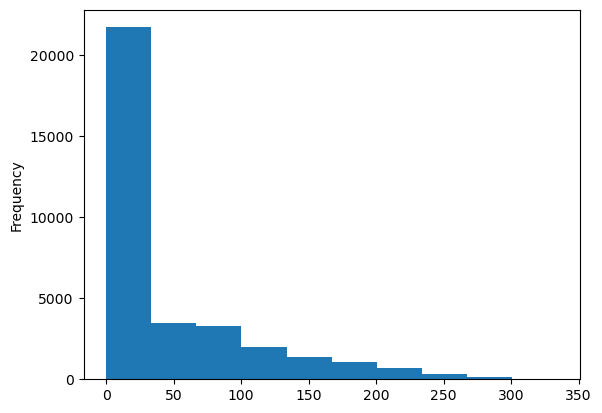

In [50]:
train['diffuse_radW'].plot.hist()


<Axes: xlabel='date_forecast'>

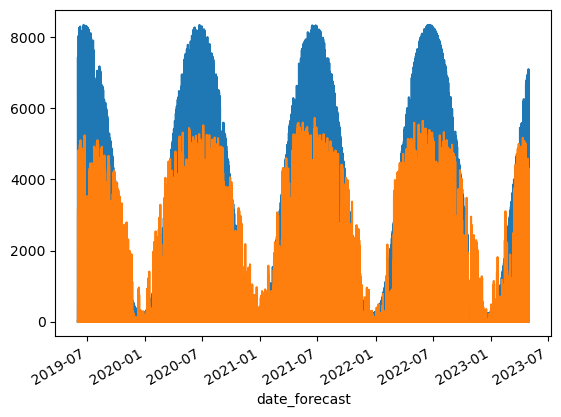

In [51]:
((train['clear_sky_radW']*train['total_cloud_coverp'])/10).plot()
(train['pv_measurement']).plot()


In [52]:
train['total_cloud_coverp'].describe()

count    34062.000000
mean        74.359434
std         33.500200
min          0.000000
25%         54.600000
50%         93.649998
75%         99.950001
max        100.000000
Name: total_cloud_coverp, dtype: float64

In [53]:
nan_col = ['snow_densitykgm3','ceiling_height_aglm','cloud_base_aglm']
test['snow_densitykgm3'].fillna(0)
for col in nan_col:
    
    test[col] = test[col].fillna(0)
    train[col] = train[col].fillna(train[col].median())

train=train.dropna()
test=test.dropna()

In [54]:
train.columns

Index(['absolute_humidity_2mgm3', 'air_density_2mkgm3', 'ceiling_height_aglm',
       'clear_sky_energy_1hJ', 'clear_sky_radW', 'cloud_base_aglm',
       'dew_or_rimeidx', 'dew_point_2mK', 'diffuse_radW', 'diffuse_rad_1hJ',
       'direct_radW', 'direct_rad_1hJ', 'effective_cloud_coverp', 'elevationm',
       'fresh_snow_12hcm', 'fresh_snow_1hcm', 'fresh_snow_24hcm',
       'fresh_snow_3hcm', 'fresh_snow_6hcm', 'is_dayidx', 'is_in_shadowidx',
       'msl_pressurehPa', 'precip_5minmm', 'precip_type_5minidx',
       'pressure_100mhPa', 'pressure_50mhPa', 'prob_rimep', 'rain_waterkgm2',
       'relative_humidity_1000hPap', 'sfc_pressurehPa', 'snow_densitykgm3',
       'snow_depthcm', 'snow_driftidx', 'snow_melt_10minmm', 'snow_waterkgm2',
       'sun_azimuthd', 'sun_elevationd', 'super_cooled_liquid_waterkgm2',
       't_1000hPaK', 'total_cloud_coverp', 'visibilitym', 'wind_speed_10mms',
       'wind_speed_u_10mms', 'wind_speed_v_10mms', 'wind_speed_w_1000hPams',
       'minute', 'hour', 

In [55]:
train.shape, test.shape

((34061, 50), (720, 48))

In [56]:
train['pv_measurement'] = train['pv_measurement'].mask(train['is_in_shadowidx'] == 1, 0)


<Axes: xlabel='date_forecast'>

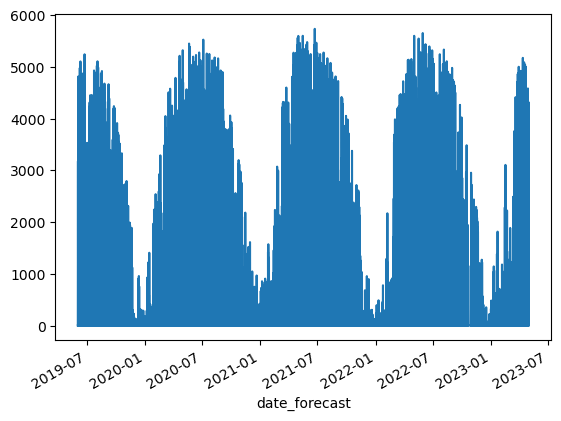

In [57]:
train['pv_measurement'].plot()

In [58]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

In [59]:
def outlier_detect_ZScore(data, col, threshold=3):
    '''
    Outlier detection by Z-Score method. 
    Calculate the Z-score for each data point.
    Any value beyond:
        upper bound = mean + (Z-score * threshold * standard deviation)
        lower bound = mean - (Z-score * threshold * standard deviation)   
    are regarded as outliers. Default threshold is 3.
    
    Parameters:
    - data: The pandas DataFrame containing the data.
    - col: The name of the column in the DataFrame to perform outlier detection on.
    - threshold: The Z-score threshold for defining outliers. Default is 3.
    
    Returns:
    - outlier_index: A boolean Series indicating which rows are outliers.
    - para: Tuple containing the upper and lower bounds for outliers.
    '''
    mean = data[col].mean()
    std = data[col].std()
    Upper_fence = mean + (threshold * std)
    Lower_fence = mean - (threshold * std)
    para = (Lower_fence, Upper_fence)
    z_scores = (data[col] - mean) / std
    outlier_index = (z_scores > threshold) | (z_scores < -threshold)
    if outlier_index.any():
        num_outliers = outlier_index.value_counts()[True]
        print(f'Num of outliers detected: {num_outliers} in column {col}')
        percentage_of_outliers = (num_outliers / len(data)) * 100
        print(f'Percentage of outliers: {percentage_of_outliers:.2f}% relative to {len(data)} data points')
        print('————————————————————————————————————————————————————')
    return outlier_index, para
def remove_outliers_ZScore(data, col, threshold=3):
    outlier_index, _ = outlier_detect_ZScore(data, col, threshold)
    data_cleaned = data[~outlier_index]
    return data_cleaned

In [60]:
for col in train.columns:
    data_without_outliers = remove_outliers_ZScore(train, col, threshold=3)


Num of outliers detected: 92 in column absolute_humidity_2mgm3
Percentage of outliers: 0.27% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 262 in column air_density_2mkgm3
Percentage of outliers: 0.77% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 552 in column ceiling_height_aglm
Percentage of outliers: 1.62% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 1019 in column cloud_base_aglm
Percentage of outliers: 2.99% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 1210 in column dew_or_rimeidx
Percentage of outliers: 3.55% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 69 in column dew_point_2mK
Percentage of outliers: 0.20% relative to 34061 data points
———————————————————————————

In [62]:
train['hours'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month
train['year'] = train.index.year
train['dayofyear'] = train.index.dayofyear

In [63]:
test['hours'] = test.index.hour
test['day'] = test.index.day
test['month'] = test.index.month
test['year'] = test.index.year
test['dayofyear'] = test.index.dayofyear

In [64]:
# Supponiamo che "gruppi" sia il risultato della suddivisione
gruppi = train.groupby('is_est')

# Itera attraverso i gruppi e crea un DataFrame separato per ciascun gruppo
dataframes_per_gruppo = {}
for valore, gruppo in gruppi:
    dataframes_per_gruppo[valore] = gruppo.copy()
train_set = dataframes_per_gruppo[0]
val_set = dataframes_per_gruppo[1]

In [65]:
train_set = train_set.drop(columns = ['is_est'])
val_set = val_set.drop(columns = ['is_est'])

In [66]:
train = train.drop(columns = ['is_est'])

In [106]:
from sklearn.model_selection import TimeSeriesSplit
data = train

# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits =2


# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


In [107]:
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
def objective(trial):
    param = {
            'metric': 'mae', 
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators',10,1000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-1),
            'max_depth': trial.suggest_int('max_depth', 1,50),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbosity': -1
        }
    model = lgb.LGBMRegressor(**param)
    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the XGBoost model
        model.fit(X_train, y_train,eval_set=[(X_test,y_test)])

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)
    # Return MAE
    mean_mae = np.mean(maelist)

    return mean_mae

In [108]:
import optuna
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)
study = optuna.create_study(direction='minimize')

[I 2023-11-01 19:26:19,320] A new study created in memory with name: no-name-4da5c434-5ae4-4a69-a184-f9e3dfd150b1


In [109]:
study.optimize(objective, n_trials=50)

Mean Absolute Error: 776.1950057391008


[I 2023-11-01 19:26:27,546] Trial 0 finished with value: 759.0445125273327 and parameters: {'n_estimators': 392, 'reg_alpha': 0.02239671107912541, 'reg_lambda': 0.36941904423475724, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.0003043108450725568, 'max_depth': 41, 'num_leaves': 322, 'min_child_samples': 26, 'min_data_per_groups': 89}. Best is trial 0 with value: 759.0445125273327.


Mean Absolute Error: 741.8940193155647
Mean Absolute Error: 650.0270606462509


[I 2023-11-01 19:26:28,819] Trial 1 finished with value: 635.2631091482642 and parameters: {'n_estimators': 216, 'reg_alpha': 0.027131555491106907, 'reg_lambda': 0.35132835749377583, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0015924838759650637, 'max_depth': 33, 'num_leaves': 940, 'min_child_samples': 259, 'min_data_per_groups': 95}. Best is trial 1 with value: 635.2631091482642.


Mean Absolute Error: 620.4991576502775
Mean Absolute Error: 836.7661689691882


[I 2023-11-01 19:26:29,917] Trial 2 finished with value: 818.9913104406596 and parameters: {'n_estimators': 104, 'reg_alpha': 0.13893256328310657, 'reg_lambda': 1.2609510435876214, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.00031548368517691236, 'max_depth': 50, 'num_leaves': 905, 'min_child_samples': 73, 'min_data_per_groups': 80}. Best is trial 1 with value: 635.2631091482642.


Mean Absolute Error: 801.2164519121309
Mean Absolute Error: 798.2952852829154


[I 2023-11-01 19:26:31,690] Trial 3 finished with value: 781.0385533107756 and parameters: {'n_estimators': 919, 'reg_alpha': 0.005929723180439493, 'reg_lambda': 8.979196514389079, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.00013451405439666474, 'max_depth': 1, 'num_leaves': 743, 'min_child_samples': 239, 'min_data_per_groups': 12}. Best is trial 1 with value: 635.2631091482642.


Mean Absolute Error: 763.7818213386358
Mean Absolute Error: 590.9296155403929


[I 2023-11-01 19:26:37,757] Trial 4 finished with value: 577.2978860107153 and parameters: {'n_estimators': 801, 'reg_alpha': 0.004463721679265648, 'reg_lambda': 0.695808352567296, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.0005802571724763706, 'max_depth': 39, 'num_leaves': 633, 'min_child_samples': 88, 'min_data_per_groups': 17}. Best is trial 4 with value: 577.2978860107153.


Mean Absolute Error: 563.6661564810377
Mean Absolute Error: 207.41592023545783


[I 2023-11-01 19:26:43,698] Trial 5 finished with value: 204.44154031513435 and parameters: {'n_estimators': 803, 'reg_alpha': 0.008848535339083786, 'reg_lambda': 0.003651534360831511, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.09426730308051455, 'max_depth': 16, 'num_leaves': 946, 'min_child_samples': 101, 'min_data_per_groups': 43}. Best is trial 5 with value: 204.44154031513435.


Mean Absolute Error: 201.46716039481086
Mean Absolute Error: 199.74715738258368


[I 2023-11-01 19:26:49,051] Trial 6 finished with value: 198.08364007643883 and parameters: {'n_estimators': 767, 'reg_alpha': 7.44627874353121, 'reg_lambda': 3.435784481112393, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.068168736694163, 'max_depth': 17, 'num_leaves': 166, 'min_child_samples': 89, 'min_data_per_groups': 30}. Best is trial 6 with value: 198.08364007643883.


Mean Absolute Error: 196.42012277029397
Mean Absolute Error: 189.77431139810315


[I 2023-11-01 19:26:56,737] Trial 7 finished with value: 189.06435486079283 and parameters: {'n_estimators': 837, 'reg_alpha': 0.16647140127026486, 'reg_lambda': 0.1396918452838811, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008523405918675947, 'max_depth': 22, 'num_leaves': 810, 'min_child_samples': 120, 'min_data_per_groups': 54}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 188.3543983234825
Mean Absolute Error: 821.3769896994743


[I 2023-11-01 19:27:02,050] Trial 8 finished with value: 803.8165077338535 and parameters: {'n_estimators': 92, 'reg_alpha': 0.0353771026674259, 'reg_lambda': 0.04827781066518596, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.0005853888242617188, 'max_depth': 36, 'num_leaves': 607, 'min_child_samples': 1, 'min_data_per_groups': 87}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 786.2560257682327
Mean Absolute Error: 830.02506303596


[I 2023-11-01 19:27:02,332] Trial 9 finished with value: 812.2632491157005 and parameters: {'n_estimators': 12, 'reg_alpha': 0.14581273679662013, 'reg_lambda': 0.11262919656474864, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.003542202284273226, 'max_depth': 38, 'num_leaves': 79, 'min_child_samples': 140, 'min_data_per_groups': 3}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 794.5014351954411
Mean Absolute Error: 189.50712513359343


[I 2023-11-01 19:27:07,030] Trial 10 finished with value: 189.5515628477827 and parameters: {'n_estimators': 598, 'reg_alpha': 0.0013756399872066273, 'reg_lambda': 0.017357242963911147, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.013487238333154022, 'max_depth': 22, 'num_leaves': 406, 'min_child_samples': 197, 'min_data_per_groups': 65}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 189.59600056197195
Mean Absolute Error: 189.6388005234968


[I 2023-11-01 19:27:11,782] Trial 11 finished with value: 189.5052074116836 and parameters: {'n_estimators': 589, 'reg_alpha': 0.0013803791491100628, 'reg_lambda': 0.01624571221249453, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.012305139797697626, 'max_depth': 22, 'num_leaves': 413, 'min_child_samples': 206, 'min_data_per_groups': 65}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 189.37161429987046
Mean Absolute Error: 189.78600835717444


[I 2023-11-01 19:27:15,595] Trial 12 finished with value: 190.16772006047307 and parameters: {'n_estimators': 561, 'reg_alpha': 0.001218905392619936, 'reg_lambda': 0.0016346294938410979, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01202180368317346, 'max_depth': 8, 'num_leaves': 445, 'min_child_samples': 179, 'min_data_per_groups': 58}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 190.54943176377174
Mean Absolute Error: 193.08211233204682


[I 2023-11-01 19:27:23,327] Trial 13 finished with value: 192.49104200514657 and parameters: {'n_estimators': 990, 'reg_alpha': 0.6166103722710106, 'reg_lambda': 0.013835314151574516, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.010023331435886091, 'max_depth': 27, 'num_leaves': 711, 'min_child_samples': 300, 'min_data_per_groups': 69}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 191.89997167824632
Mean Absolute Error: 196.7108485594465


[I 2023-11-01 19:27:31,056] Trial 14 finished with value: 194.68299830143116 and parameters: {'n_estimators': 653, 'reg_alpha': 0.46822445729424145, 'reg_lambda': 0.0828227389917331, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02883265259485672, 'max_depth': 26, 'num_leaves': 298, 'min_child_samples': 142, 'min_data_per_groups': 42}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 192.65514804341578
Mean Absolute Error: 292.2166915519836


[I 2023-11-01 19:27:34,273] Trial 15 finished with value: 290.218280047676 and parameters: {'n_estimators': 412, 'reg_alpha': 0.0011317240848810835, 'reg_lambda': 0.009080718411528884, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.00421487407784097, 'max_depth': 12, 'num_leaves': 790, 'min_child_samples': 214, 'min_data_per_groups': 52}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 288.2198685433684
Mean Absolute Error: 194.7842161066272


[I 2023-11-01 19:27:40,634] Trial 16 finished with value: 192.86558193894498 and parameters: {'n_estimators': 698, 'reg_alpha': 0.043813839108640174, 'reg_lambda': 0.034866174747690284, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.027259376811675205, 'max_depth': 20, 'num_leaves': 571, 'min_child_samples': 163, 'min_data_per_groups': 75}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 190.94694777126276
Mean Absolute Error: 209.5216257521261


[I 2023-11-01 19:27:44,914] Trial 17 finished with value: 209.6956211163793 and parameters: {'n_estimators': 454, 'reg_alpha': 0.0036223527194271157, 'reg_lambda': 0.13898157937121736, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.006901606105004974, 'max_depth': 30, 'num_leaves': 508, 'min_child_samples': 135, 'min_data_per_groups': 30}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 209.86961648063252
Mean Absolute Error: 453.0284475755577


[I 2023-11-01 19:27:46,574] Trial 18 finished with value: 443.7904881491657 and parameters: {'n_estimators': 286, 'reg_alpha': 0.01636284732630673, 'reg_lambda': 0.00615345662557117, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.0030126779000970863, 'max_depth': 8, 'num_leaves': 301, 'min_child_samples': 229, 'min_data_per_groups': 59}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 434.5525287227737
Mean Absolute Error: 197.617545149552


[I 2023-11-01 19:27:58,090] Trial 19 finished with value: 194.922695396709 and parameters: {'n_estimators': 916, 'reg_alpha': 0.09966446898097273, 'reg_lambda': 0.02672730595263574, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.024376978970585314, 'max_depth': 24, 'num_leaves': 796, 'min_child_samples': 55, 'min_data_per_groups': 44}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 192.227845643866
Mean Absolute Error: 357.5189005425867


[I 2023-11-01 19:28:02,031] Trial 20 finished with value: 353.47966435134424 and parameters: {'n_estimators': 696, 'reg_alpha': 0.0031961158311060106, 'reg_lambda': 0.001812809767468391, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.0018439041914078004, 'max_depth': 47, 'num_leaves': 188, 'min_child_samples': 267, 'min_data_per_groups': 32}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 349.4404281601018
Mean Absolute Error: 190.28757009642322


[I 2023-11-01 19:28:06,456] Trial 21 finished with value: 189.7956716136427 and parameters: {'n_estimators': 570, 'reg_alpha': 0.0011344164366361897, 'reg_lambda': 0.01769804831270297, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.014327070541952583, 'max_depth': 21, 'num_leaves': 434, 'min_child_samples': 193, 'min_data_per_groups': 66}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 189.30377313086214
Mean Absolute Error: 196.88234168964956


[I 2023-11-01 19:28:10,665] Trial 22 finished with value: 198.3677614679703 and parameters: {'n_estimators': 580, 'reg_alpha': 0.002443077036742485, 'reg_lambda': 0.017902230933650124, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.0067323083229676286, 'max_depth': 23, 'num_leaves': 383, 'min_child_samples': 201, 'min_data_per_groups': 62}. Best is trial 7 with value: 189.06435486079283.


Mean Absolute Error: 199.853181246291
Mean Absolute Error: 188.87347523536144


[I 2023-11-01 19:28:14,320] Trial 23 finished with value: 188.09158137364926 and parameters: {'n_estimators': 511, 'reg_alpha': 0.009372444052621472, 'reg_lambda': 0.04779199226288626, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.016915344482320575, 'max_depth': 15, 'num_leaves': 513, 'min_child_samples': 120, 'min_data_per_groups': 72}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 187.30968751193706
Mean Absolute Error: 192.85458377761003


[I 2023-11-01 19:28:16,612] Trial 24 finished with value: 190.44123745786976 and parameters: {'n_estimators': 325, 'reg_alpha': 0.009176184077849847, 'reg_lambda': 0.05393431084995254, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.044720568866823227, 'max_depth': 13, 'num_leaves': 511, 'min_child_samples': 116, 'min_data_per_groups': 77}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 188.0278911381295
Mean Absolute Error: 189.90990470711645


[I 2023-11-01 19:28:20,613] Trial 25 finished with value: 189.243223006859 and parameters: {'n_estimators': 495, 'reg_alpha': 0.01211159926296053, 'reg_lambda': 0.19745648990369885, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.020545093213866536, 'max_depth': 30, 'num_leaves': 858, 'min_child_samples': 164, 'min_data_per_groups': 52}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 188.57654130660157
Mean Absolute Error: 190.0383309518535


[I 2023-11-01 19:28:24,594] Trial 26 finished with value: 189.51887926073303 and parameters: {'n_estimators': 481, 'reg_alpha': 0.013389745365230429, 'reg_lambda': 0.17432069942392184, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02111220541749103, 'max_depth': 30, 'num_leaves': 843, 'min_child_samples': 169, 'min_data_per_groups': 53}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 188.99942756961255
Mean Absolute Error: 193.7100010659789


[I 2023-11-01 19:28:26,959] Trial 27 finished with value: 191.4493345929385 and parameters: {'n_estimators': 328, 'reg_alpha': 0.00716982961902655, 'reg_lambda': 0.08214706569339932, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.05190988161479474, 'max_depth': 17, 'num_leaves': 681, 'min_child_samples': 118, 'min_data_per_groups': 36}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 189.1886681198981
Mean Absolute Error: 190.10100376908207


[I 2023-11-01 19:28:29,913] Trial 28 finished with value: 188.76372495877274 and parameters: {'n_estimators': 228, 'reg_alpha': 0.013324712658887482, 'reg_lambda': 0.2312432028902359, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.03605990874965017, 'max_depth': 29, 'num_leaves': 864, 'min_child_samples': 54, 'min_data_per_groups': 51}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 187.4264461484634
Mean Absolute Error: 190.01273135162882


[I 2023-11-01 19:28:32,851] Trial 29 finished with value: 189.26066356857888 and parameters: {'n_estimators': 207, 'reg_alpha': 0.05664315299586951, 'reg_lambda': 0.3301324670489722, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.03963279446243845, 'max_depth': 44, 'num_leaves': 981, 'min_child_samples': 59, 'min_data_per_groups': 85}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 188.5085957855289
Mean Absolute Error: 232.09349191546752


[I 2023-11-01 19:28:33,777] Trial 30 finished with value: 236.17876440032546 and parameters: {'n_estimators': 386, 'reg_alpha': 0.017220894563558874, 'reg_lambda': 0.6320410012257566, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.08388338248997108, 'max_depth': 1, 'num_leaves': 867, 'min_child_samples': 26, 'min_data_per_groups': 22}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 240.26403688518337
Mean Absolute Error: 199.77980091800669


[I 2023-11-01 19:28:37,079] Trial 31 finished with value: 198.82759661979657 and parameters: {'n_estimators': 209, 'reg_alpha': 0.020076687610177835, 'reg_lambda': 0.21663965179593636, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.0172428660863109, 'max_depth': 29, 'num_leaves': 816, 'min_child_samples': 34, 'min_data_per_groups': 49}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 197.87539232158645
Mean Absolute Error: 193.37787523486435


[I 2023-11-01 19:28:42,110] Trial 32 finished with value: 192.09461585898316 and parameters: {'n_estimators': 508, 'reg_alpha': 0.012025922109301706, 'reg_lambda': 0.21144750948745877, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.03589953191986871, 'max_depth': 34, 'num_leaves': 897, 'min_child_samples': 157, 'min_data_per_groups': 72}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 190.811356483102
Mean Absolute Error: 220.16004819227967


[I 2023-11-01 19:28:43,822] Trial 33 finished with value: 219.44652121452106 and parameters: {'n_estimators': 135, 'reg_alpha': 0.025812823781034694, 'reg_lambda': 0.07685151187564791, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.020391368024518068, 'max_depth': 31, 'num_leaves': 992, 'min_child_samples': 110, 'min_data_per_groups': 57}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 218.73299423676244
Mean Absolute Error: 192.86643211442868


[I 2023-11-01 19:28:47,265] Trial 34 finished with value: 191.02879692114357 and parameters: {'n_estimators': 253, 'reg_alpha': 0.007625830761755529, 'reg_lambda': 0.3881209537214419, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.05099057382210275, 'max_depth': 34, 'num_leaves': 772, 'min_child_samples': 61, 'min_data_per_groups': 100}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 189.19116172785849
Mean Absolute Error: 205.79642858061345


[I 2023-11-01 19:28:49,976] Trial 35 finished with value: 206.57724337471336 and parameters: {'n_estimators': 377, 'reg_alpha': 0.004573111905717358, 'reg_lambda': 0.14301768243485835, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.008578554078546224, 'max_depth': 27, 'num_leaves': 669, 'min_child_samples': 128, 'min_data_per_groups': 48}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 207.35805816881327
Mean Absolute Error: 194.5050839521496


[I 2023-11-01 19:28:59,030] Trial 36 finished with value: 191.932375526221 and parameters: {'n_estimators': 925, 'reg_alpha': 0.023417935714794284, 'reg_lambda': 0.04257164560766181, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.018798796594497277, 'max_depth': 19, 'num_leaves': 919, 'min_child_samples': 85, 'min_data_per_groups': 36}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 189.3596671002924
Mean Absolute Error: 193.4197903130472


[I 2023-11-01 19:29:04,684] Trial 37 finished with value: 191.09470691227378 and parameters: {'n_estimators': 763, 'reg_alpha': 0.005601052610218275, 'reg_lambda': 1.2303216170091975, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.03283582224473411, 'max_depth': 13, 'num_leaves': 726, 'min_child_samples': 44, 'min_data_per_groups': 80}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 188.76962351150036
Mean Absolute Error: 189.9684453987624


[I 2023-11-01 19:29:05,777] Trial 38 finished with value: 188.79445614997815 and parameters: {'n_estimators': 145, 'reg_alpha': 0.010685632324710094, 'reg_lambda': 0.32148078759285276, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.06727512542712982, 'max_depth': 7, 'num_leaves': 570, 'min_child_samples': 8, 'min_data_per_groups': 94}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 187.62046690119385
Mean Absolute Error: 470.024652431268


[I 2023-11-01 19:29:06,061] Trial 39 finished with value: 460.8191307251222 and parameters: {'n_estimators': 11, 'reg_alpha': 0.07090904033064611, 'reg_lambda': 0.3577989392774156, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.06950091719750605, 'max_depth': 6, 'num_leaves': 560, 'min_child_samples': 12, 'min_data_per_groups': 91}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 451.6136090189764
Mean Absolute Error: 190.98191346835742


[I 2023-11-01 19:29:06,830] Trial 40 finished with value: 191.27584904869718 and parameters: {'n_estimators': 154, 'reg_alpha': 0.027744661475692968, 'reg_lambda': 0.06443088267977025, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.0634358551427955, 'max_depth': 5, 'num_leaves': 610, 'min_child_samples': 80, 'min_data_per_groups': 94}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 191.56978462903695
Mean Absolute Error: 192.89630380926948


[I 2023-11-01 19:29:11,178] Trial 41 finished with value: 193.63060023940855 and parameters: {'n_estimators': 168, 'reg_alpha': 0.010196247991740038, 'reg_lambda': 0.09353143553701153, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.09732767954389412, 'max_depth': 15, 'num_leaves': 929, 'min_child_samples': 8, 'min_data_per_groups': 100}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 194.36489666954762
Mean Absolute Error: 228.9989224413667


[I 2023-11-01 19:29:12,100] Trial 42 finished with value: 228.4623107840962 and parameters: {'n_estimators': 85, 'reg_alpha': 0.005921255805081507, 'reg_lambda': 0.2232044413897152, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.029477228513309372, 'max_depth': 10, 'num_leaves': 865, 'min_child_samples': 100, 'min_data_per_groups': 82}. Best is trial 23 with value: 188.09158137364926.


Mean Absolute Error: 227.9256991268257
Mean Absolute Error: 223.58843145969652


[I 2023-11-01 19:29:12,500] Trial 43 finished with value: 228.16741660716158 and parameters: {'n_estimators': 64, 'reg_alpha': 0.0023347991737595573, 'reg_lambda': 0.11872930073407915, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.042965258444116736, 'max_depth': 4, 'num_leaves': 748, 'min_child_samples': 181, 'min_data_per_groups': 44}. Best is trial 23 with value: 188.09158137364926.
[W 2023-11-01 19:29:12,560] Trial 44 failed with parameters: {'n_estimators': 818, 'reg_alpha': 0.011919673606835069, 'reg_lambda': 0.5142641638702872, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01802973469713538, 'max_depth': 37, 'num_leaves': 1, 'min_child_samples': 70, 'min_data_per_groups': 69} because of the following error: LightGBMError('Check failed: (num_leaves) > (1) at D:\\a\\1\\s\\lightgbm-python\\src\\io\\config_auto.cpp, line 342 .\n').
Traceback (most recent call last):
  File "C:\Users\claxl\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 20

Mean Absolute Error: 232.74640175462665


LightGBMError: Check failed: (num_leaves) > (1) at D:\a\1\s\lightgbm-python\src\io\config_auto.cpp, line 342 .


In [110]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 188.09158137364926
{'n_estimators': 511, 'reg_alpha': 0.009372444052621472, 'reg_lambda': 0.04779199226288626, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.016915344482320575, 'max_depth': 15, 'num_leaves': 513, 'min_child_samples': 120, 'min_data_per_groups': 72}


In [111]:
param = {'n_estimators': 352, 'reg_alpha': 0.003142082634552811, 'reg_lambda': 0.02020074558999535, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.026901602727684413, 'max_depth': 13, 'num_leaves': 192, 'min_child_samples': 57, 'min_data_per_groups': 28}

In [112]:
model_A = lgb.LGBMRegressor(**param)

In [113]:
X_train = train.drop(columns = 'pv_measurement')
y_train = train['pv_measurement']

In [114]:
pd.set_option('display.max_columns', 184)

test.shape,train.shape

((720, 64), (34061, 65))

In [115]:
model_A.fit(X_train,y_train)
y_pred_A = model_A.predict(test)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10875
[LightGBM] [Info] Number of data points in the train set: 34061, number of used features: 59
[LightGBM] [Info] Start training from score 629.398666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


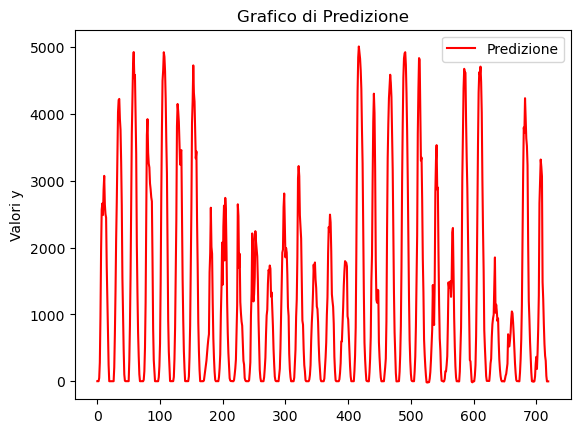

In [116]:
plt.plot(range(len(y_pred_A)), (y_pred_A), label='Predizione', color='red', linestyle='-')
# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [117]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [118]:
test = test.reset_index()
df.loc[test['is_in_shadowidx'] == 1, 'Prediction'] = 0


In [119]:
df.to_csv('A5.csv')

In [120]:
df

Prediction
0      0.000000
1      0.000000
2      0.000000
3     49.317985
4    280.625220
..          ...
715  307.166398
716   79.626692
717    0.000000
718    0.000000
719    0.000000

[720 rows x 1 columns]

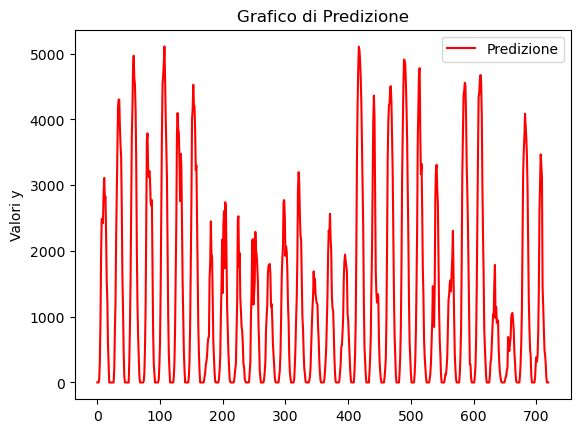

In [416]:
plt.plot(range(len(y_pred_A)), (df['Prediction']), label='Predizione', color='red', linestyle='-')
# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [68]:
train['Radiazione_solare_effettiva'] = (train['direct_radW']) + (train['effective_cloud_coverp'])

test['Radiazione_solare_effettiva'] = (test['direct_radW'] ) + (test['effective_cloud_coverp'])
train['Radiazione_solare_effettiva'] = (train['direct_rad_1hJ']) + (train['effective_cloud_coverp'])

test['Radiazione_solare_effettiva'] = (test['direct_rad_1hJ'] ) + (test['effective_cloud_coverp'])

In [69]:
train['radmul'] = (train['direct_radW'] + train['diffuse_radW']) * (1 - train['effective_cloud_coverp'])/100
test['radmul'] = (test['direct_radW'] + test['diffuse_radW']) * (1 - test['effective_cloud_coverp'])/100

In [70]:
train['raddir'] = (train['direct_radW'] ) * (train['absolute_humidity_2mgm3'])
test['raddir'] = (test['direct_radW'] ) * (test['absolute_humidity_2mgm3'])

In [71]:
train['wind3'] = train['wind_speed_10mms'] * train['cloud_base_aglm']
test['wind3'] = test['wind_speed_10mms'] * test['cloud_base_aglm']

In [72]:
train['winddif'] = train['wind_speed_10mms'] * train['diffuse_radW']
test['winddif'] = test['wind_speed_10mms'] * test['diffuse_radW']

In [87]:
train['winddir'] = train['wind_speed_10mms'] * train['direct_radW']
test['winddir'] = test['wind_speed_10mms'] * test['direct_radW']

In [88]:
train['winddirV'] = train['wind_speed_v_10mms'] * train['direct_radW']
test['winddirV'] = test['wind_speed_v_10mms'] * test['direct_radW']

In [74]:
train['windceil'] = train['wind_speed_10mms'] * train['ceiling_height_aglm']
test['windceil'] = test['wind_speed_10mms'] * test['ceiling_height_aglm']

In [75]:
train['ceilrad'] = train['direct_radW'] * train['ceiling_height_aglm']
test['ceilrad'] = test['ceiling_height_aglm'] * test['direct_radW']
train['clearcloud'] =   train['clear_sky_radW']*train['total_cloud_coverp']
test['clearcloud'] =   test['clear_sky_radW']*test['total_cloud_coverp']

In [76]:
train['Radiazione_solare_effettivaH'] = train['Radiazione_solare_effettiva'] * train['hour']

test['Radiazione_solare_effettivaH'] = test['Radiazione_solare_effettiva'] * test['hour']

<Axes: xlabel='date_forecast'>

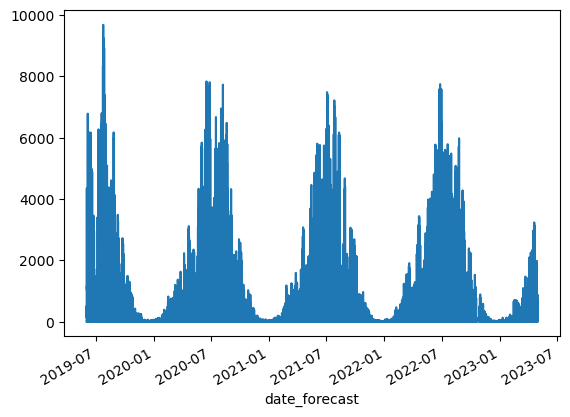

In [100]:
train['effectivehum'] = (train['absolute_humidity_2mgm3']) * (train['direct_radW'])

test['effectivehum'] = (test['absolute_humidity_2mgm3']) * (test['direct_radW'])
train['effectivehum'].plot()

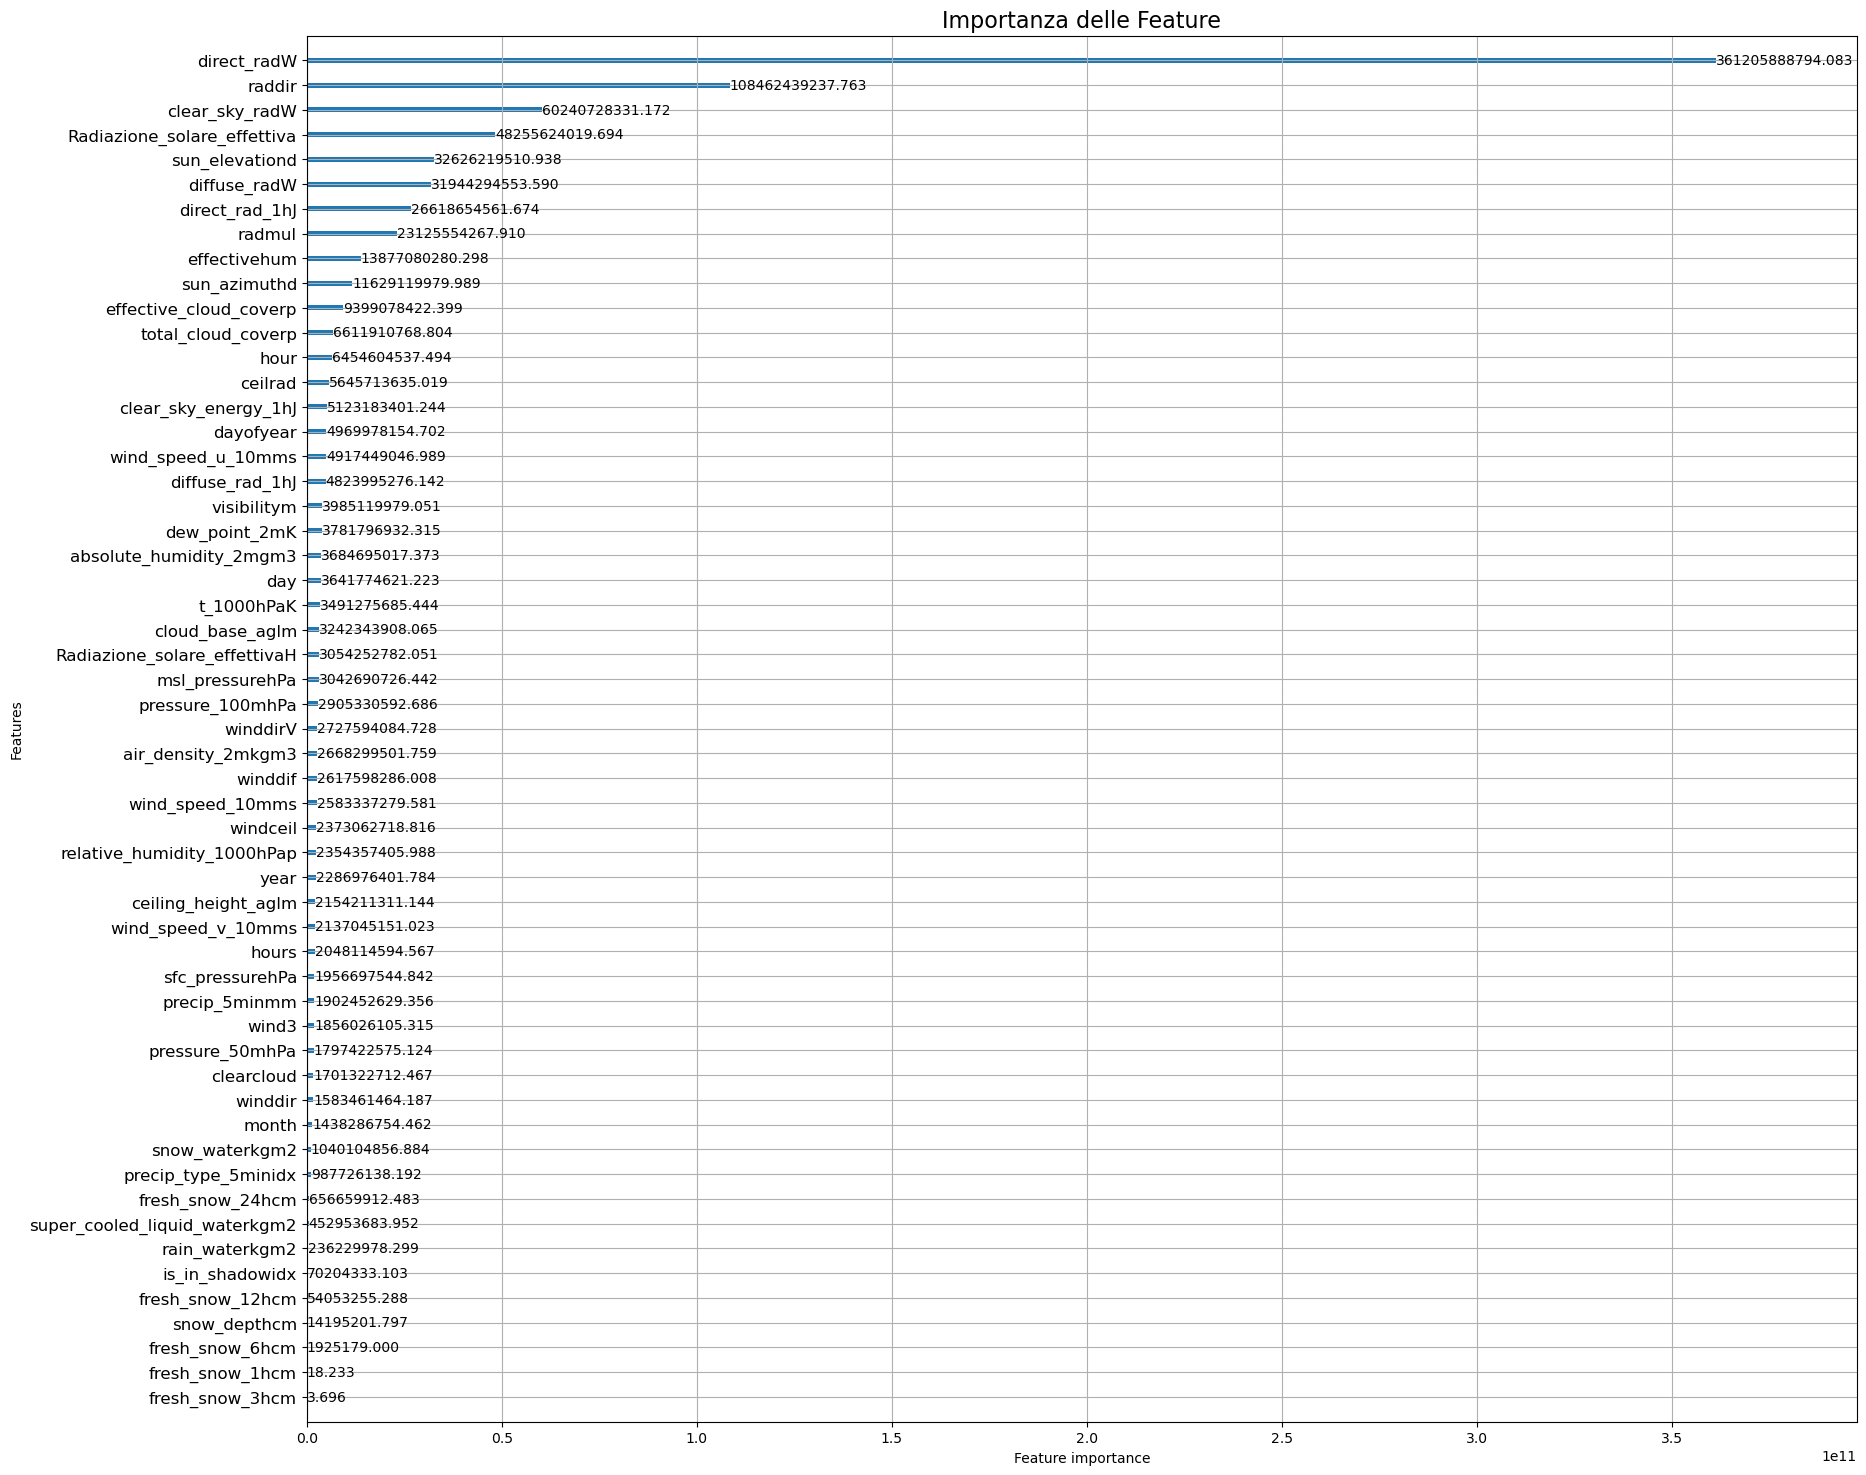

In [105]:
lgb.plot_importance(model_A, importance_type='gain', figsize=(20, 18))

# Aggiungi un'etichetta al grafico
plt.title("Importanza delle Feature", fontsize=16)

# Regola la dimensione dei tick sull'asse y
plt.yticks(fontsize=12)

# Mostra il grafico
plt.show()

In [ ]:
train = train.drop(columns = 'ceilcloud')

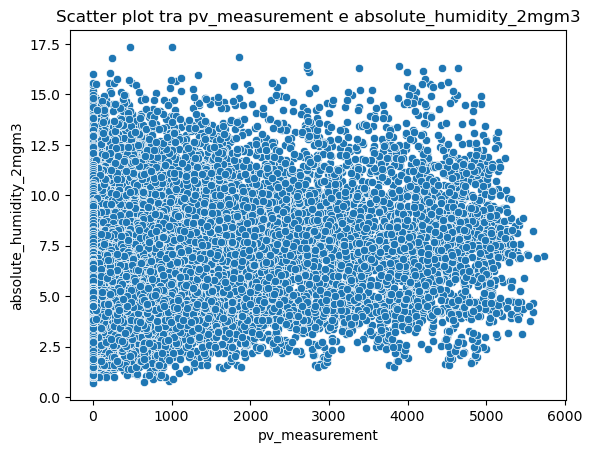

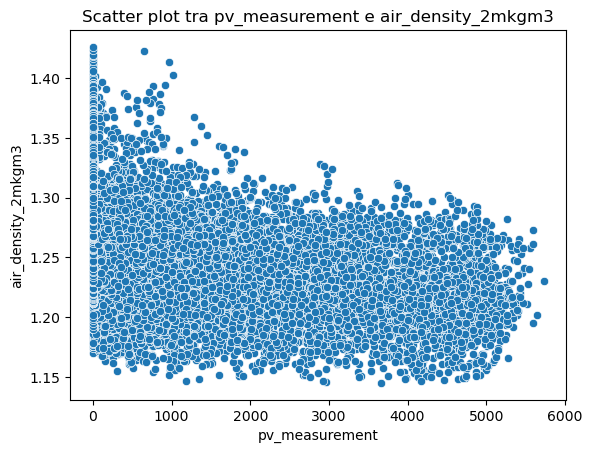

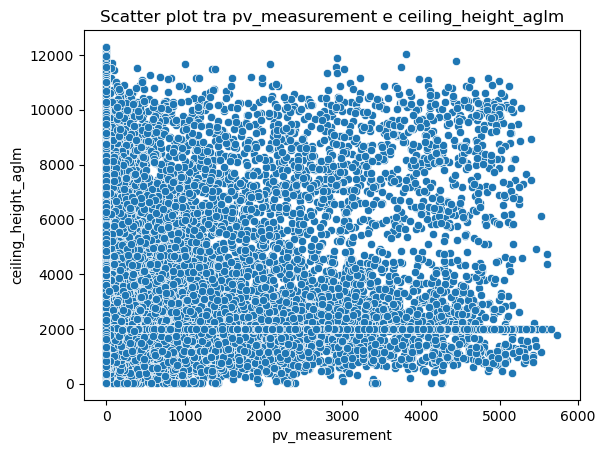

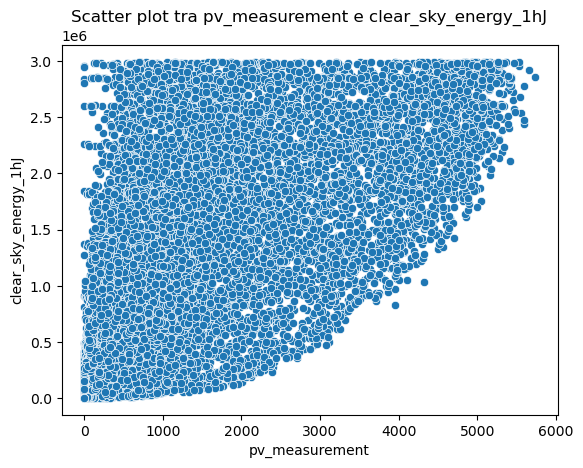

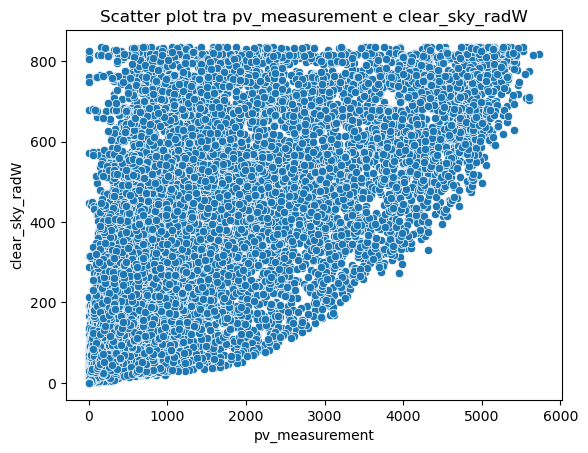

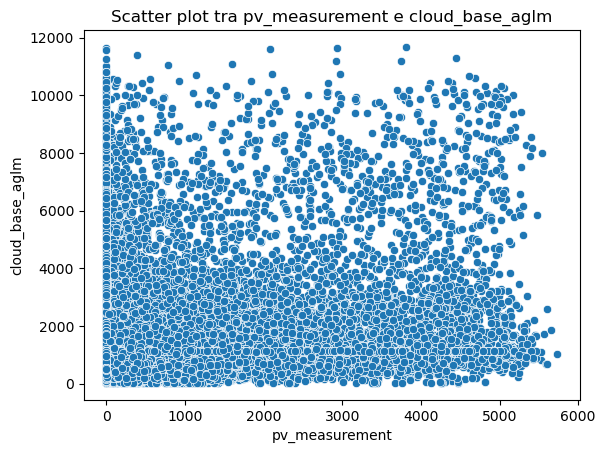

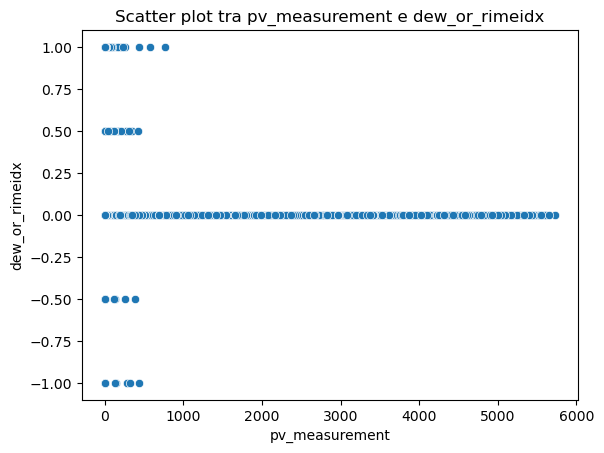

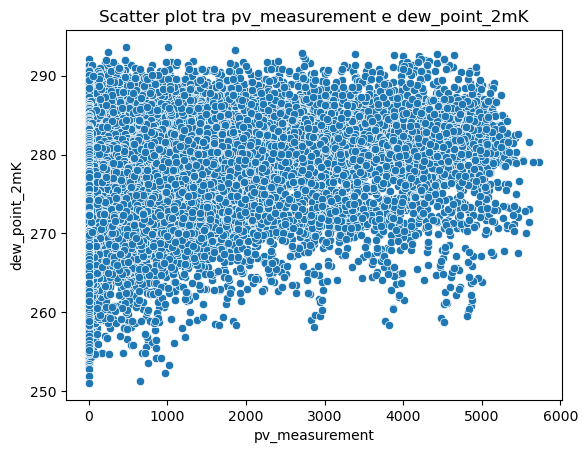

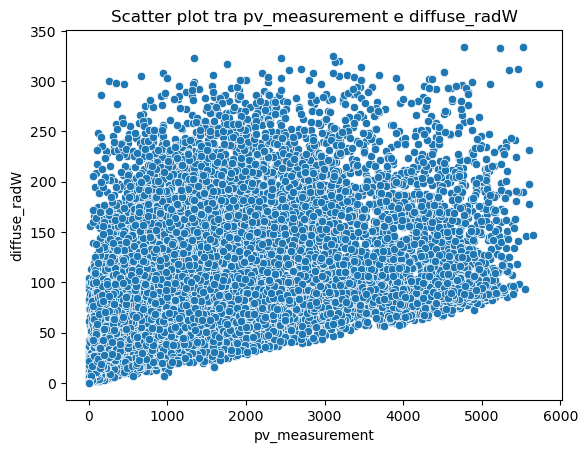

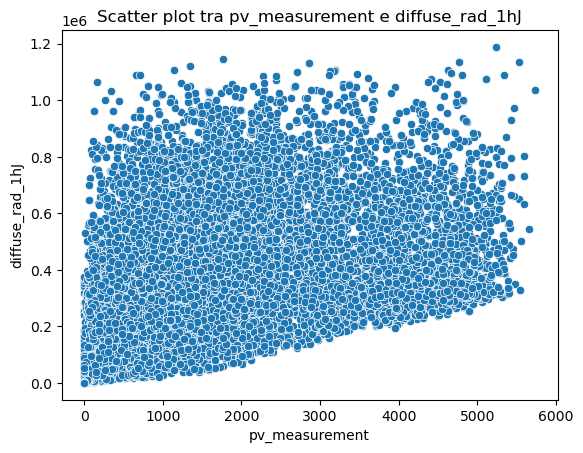

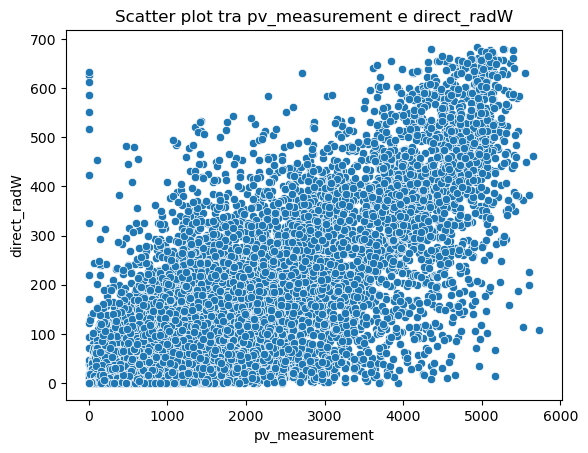

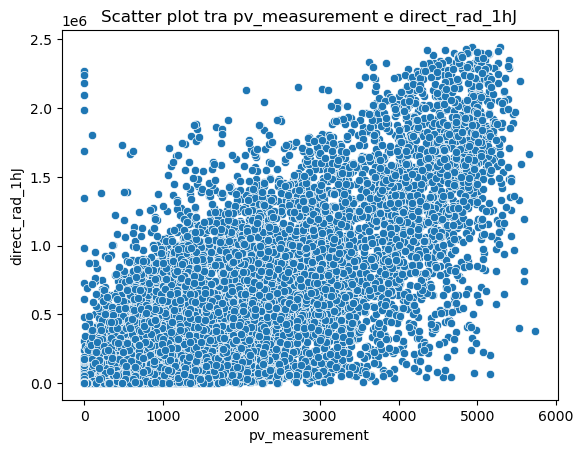

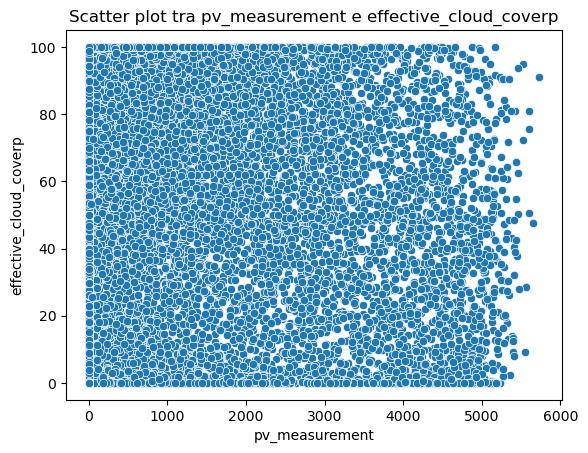

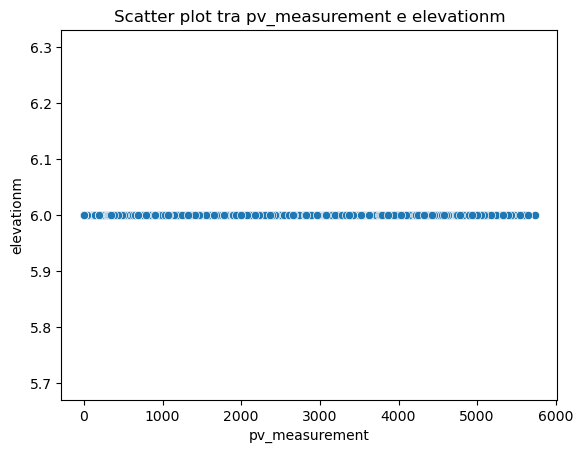

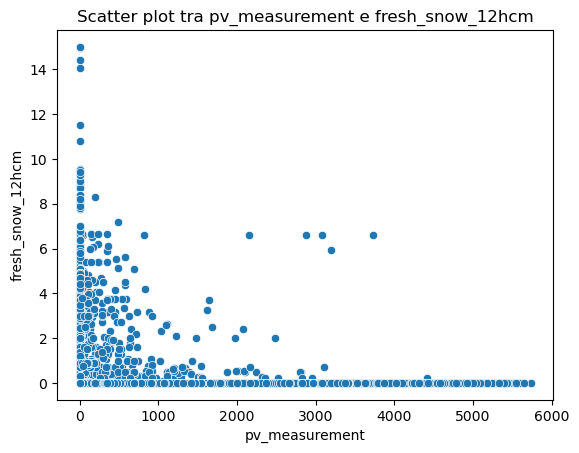

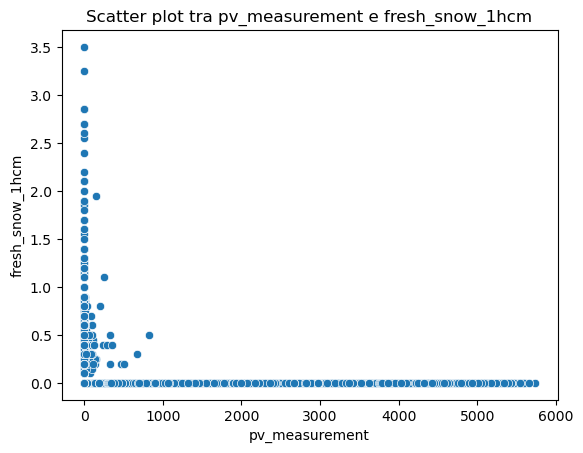

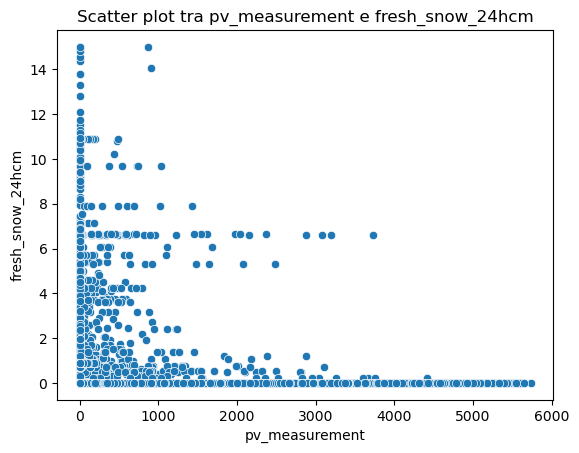

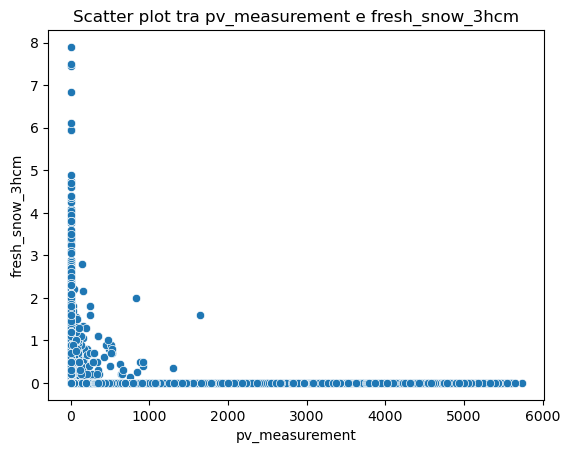

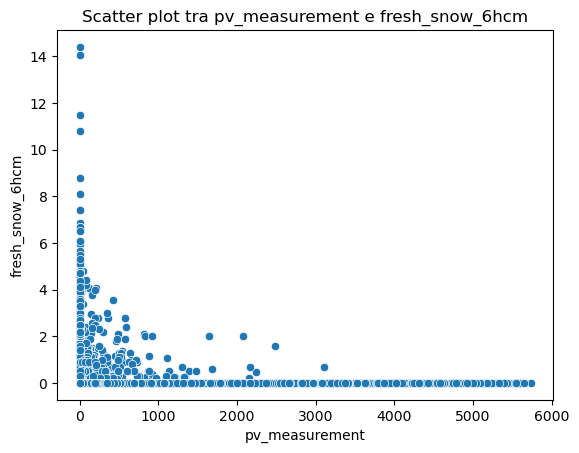

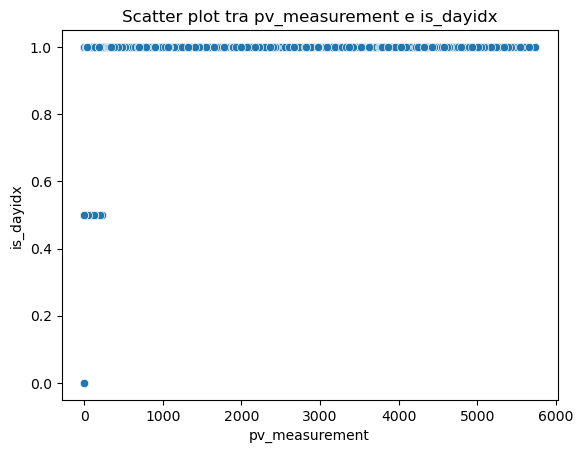

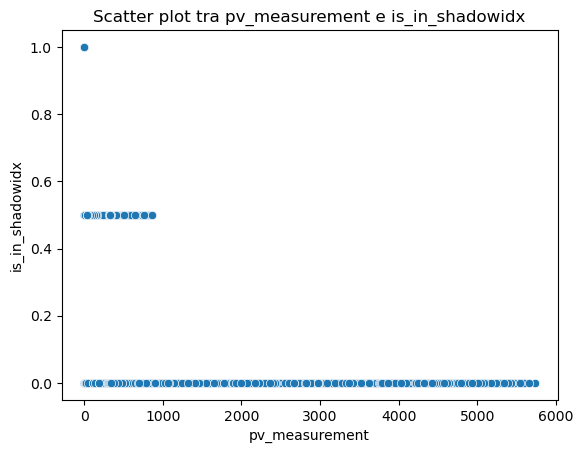

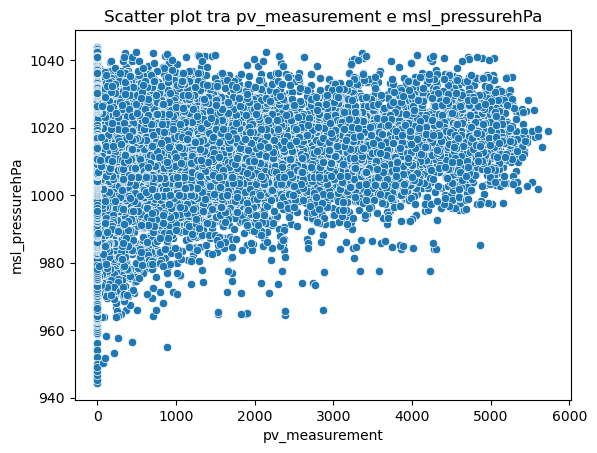

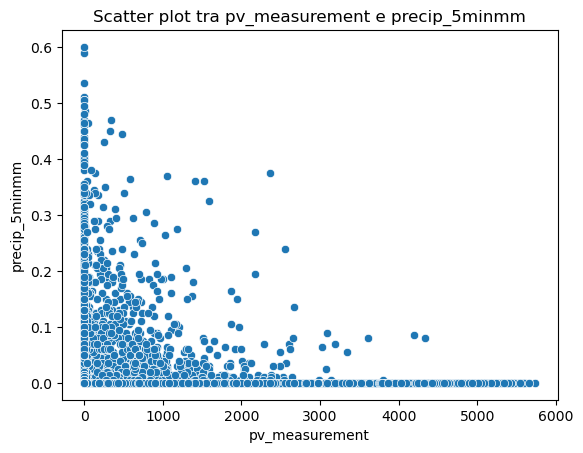

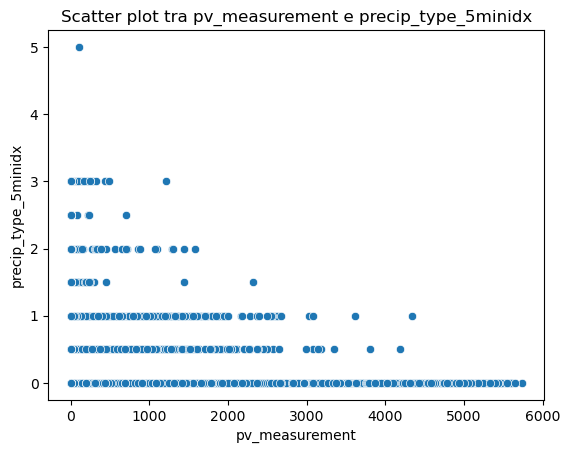

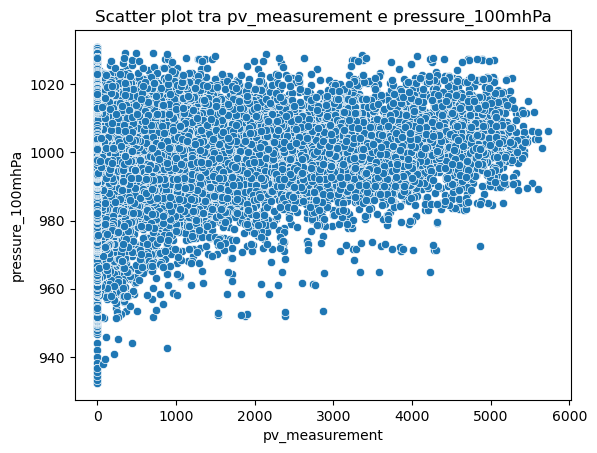

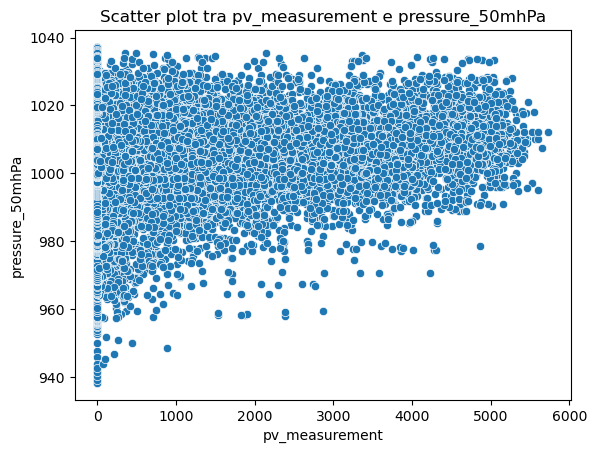

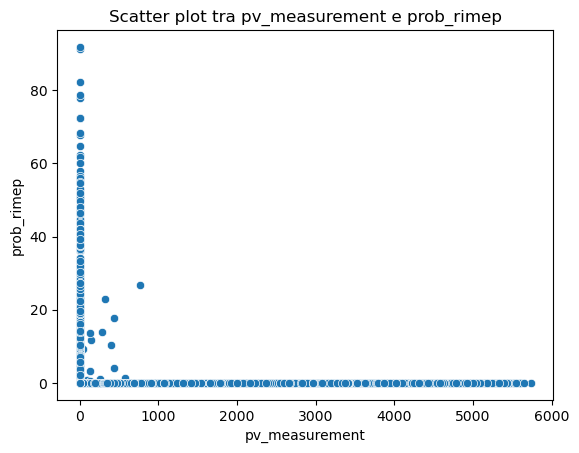

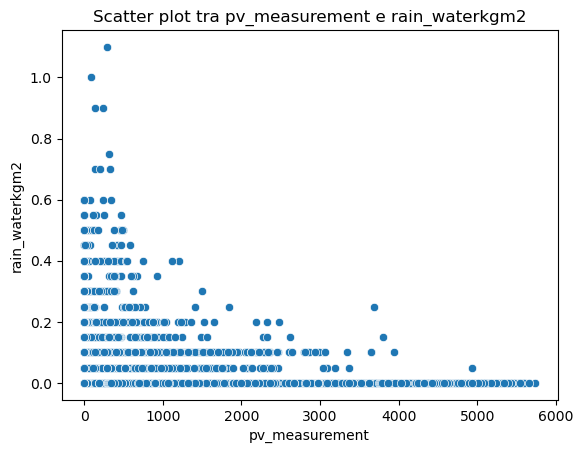

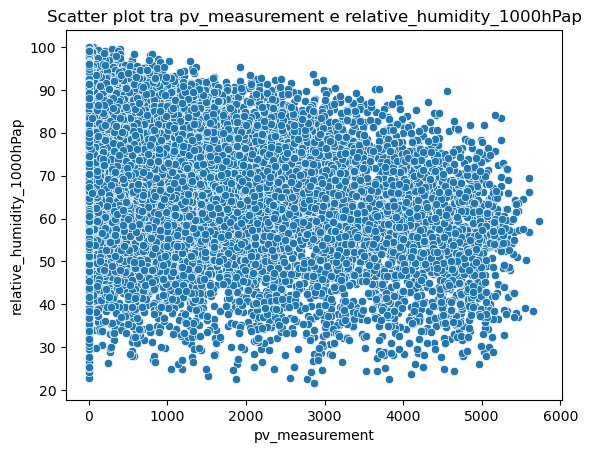

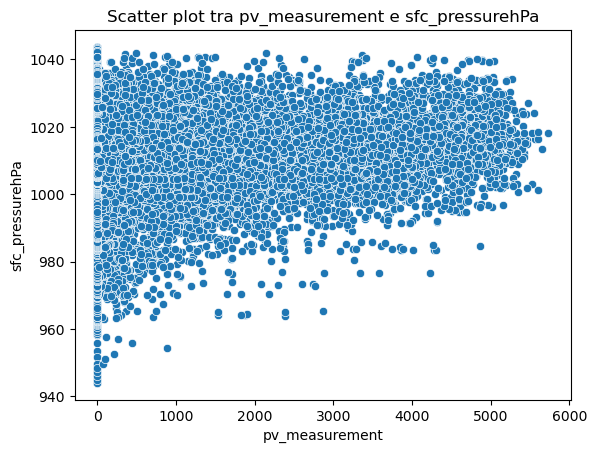

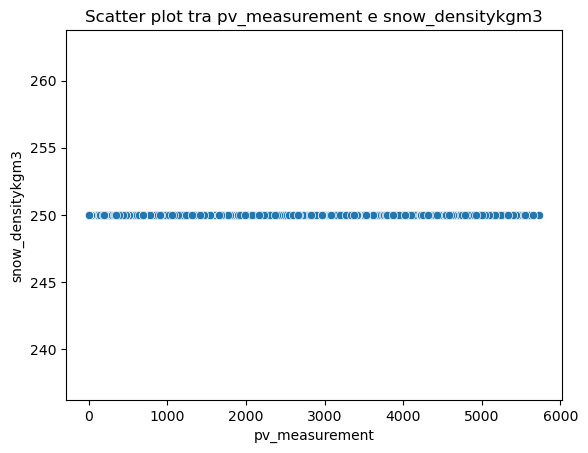

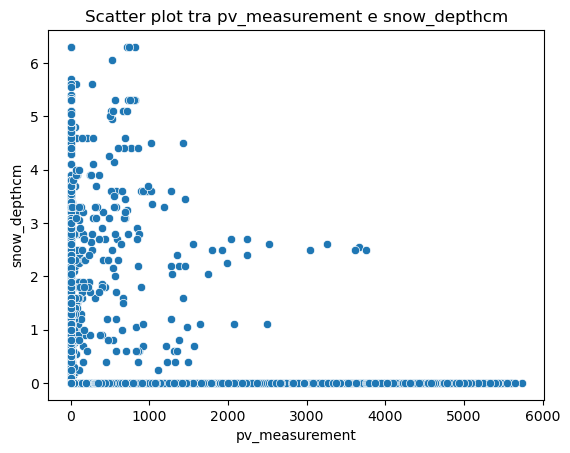

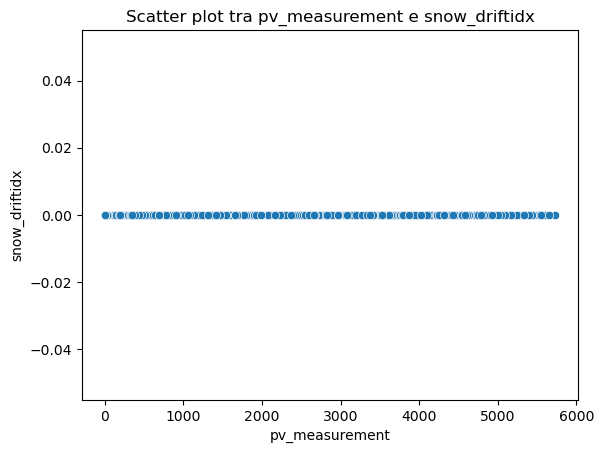

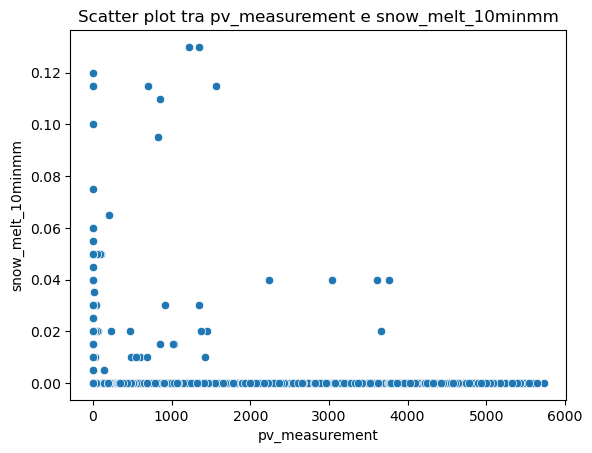

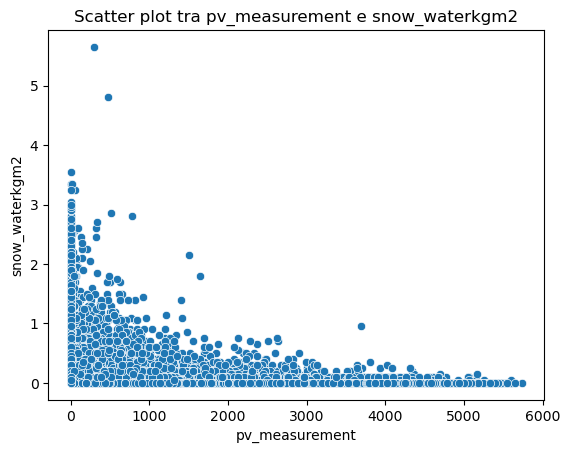

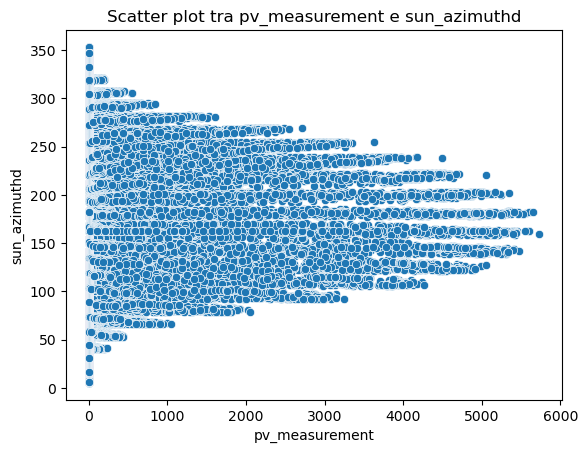

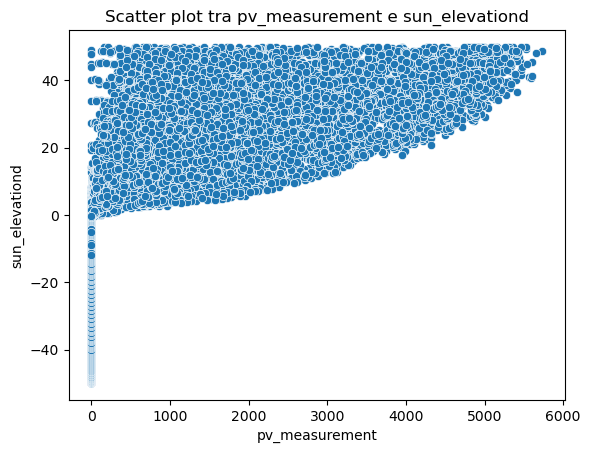

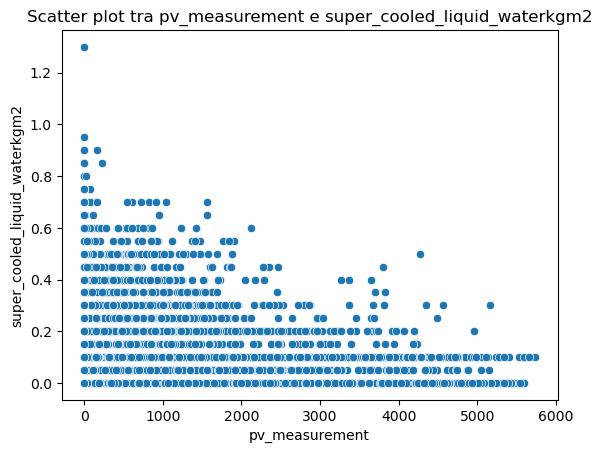

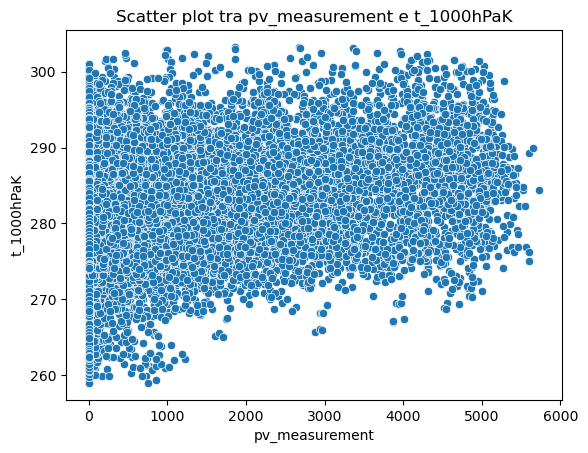

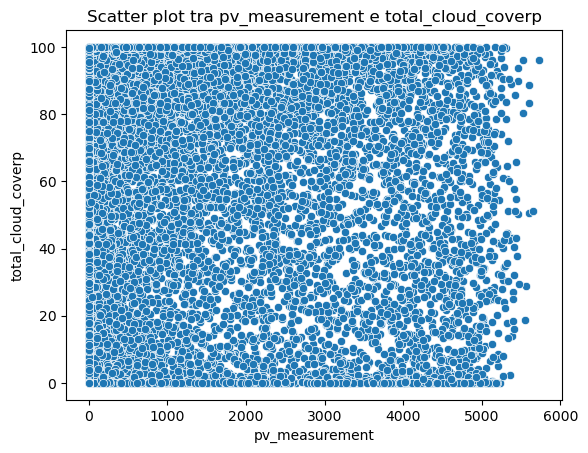

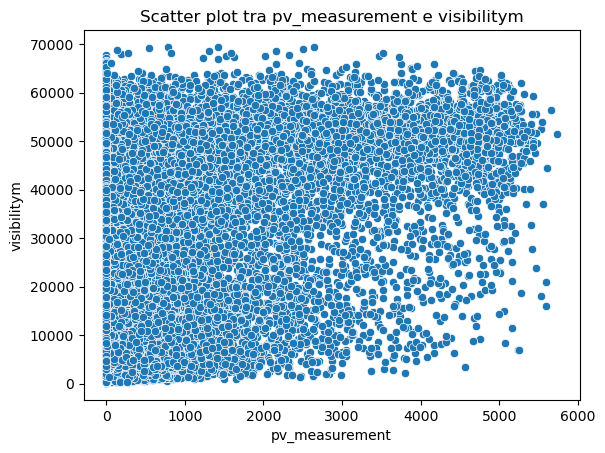

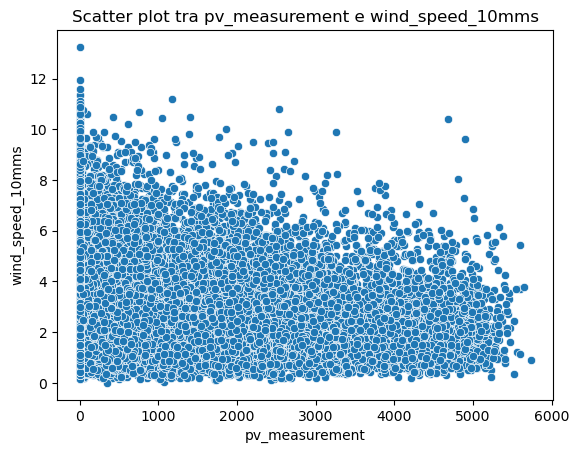

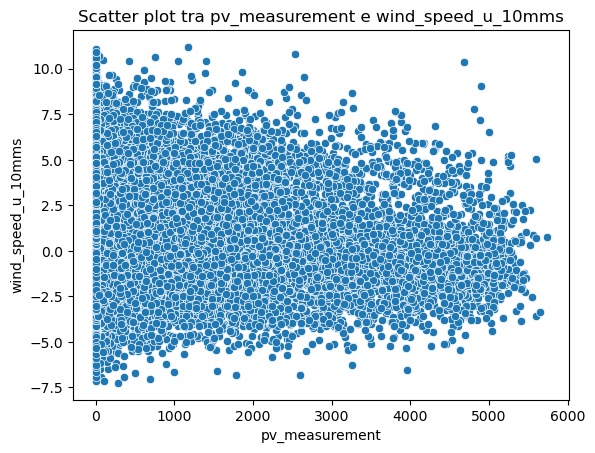

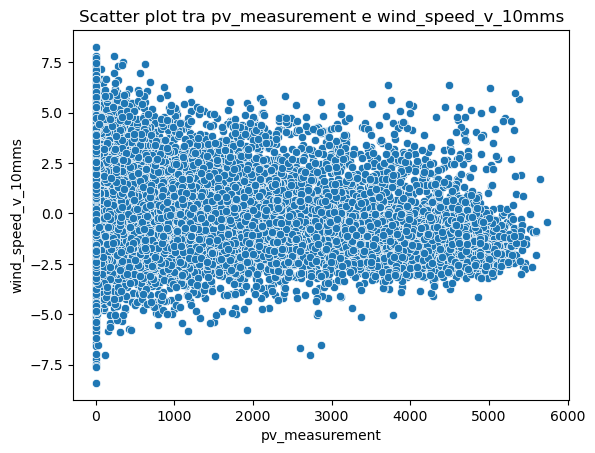

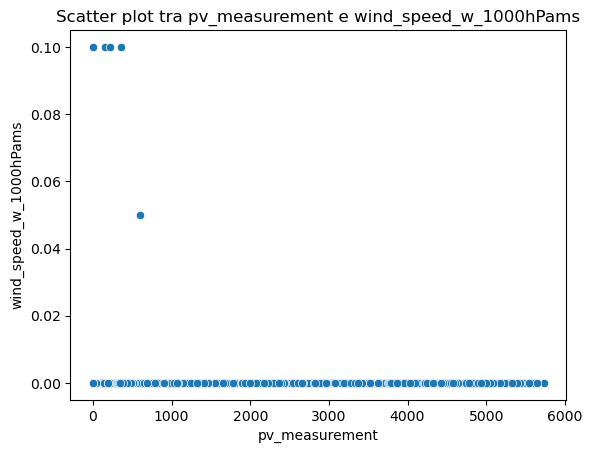

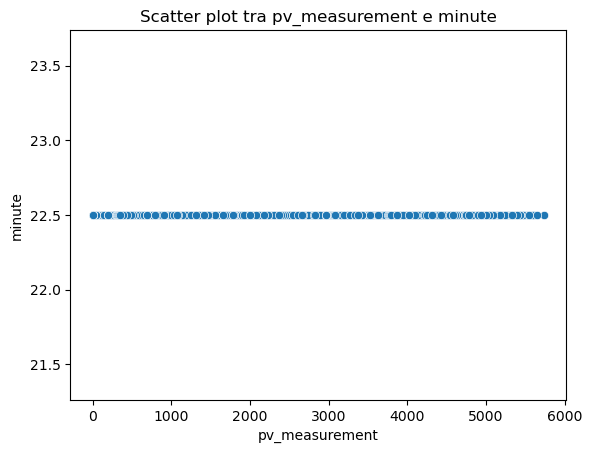

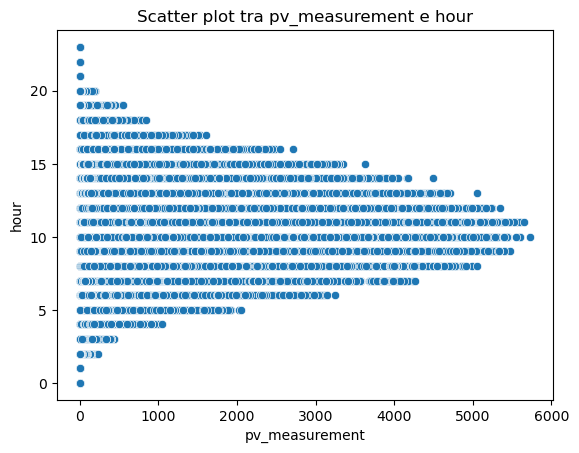

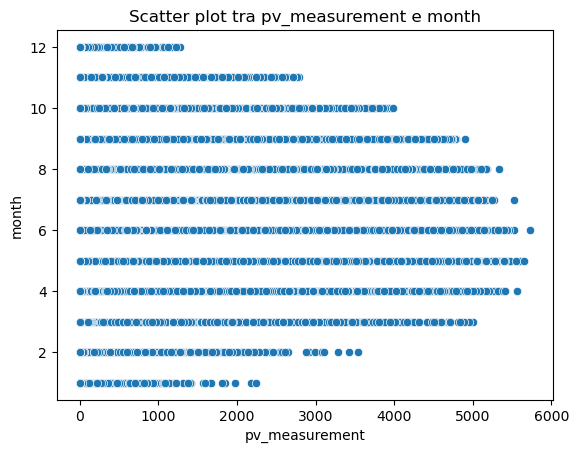

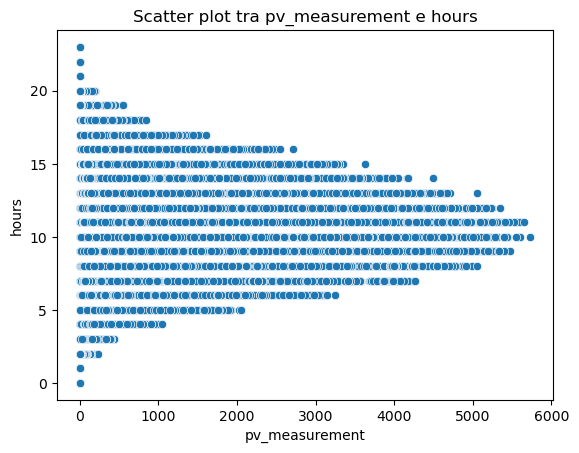

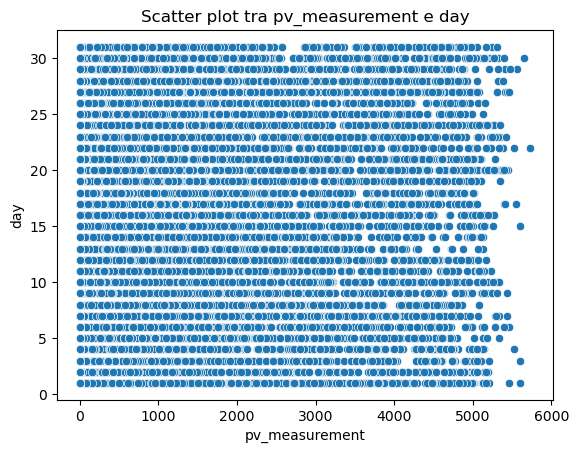

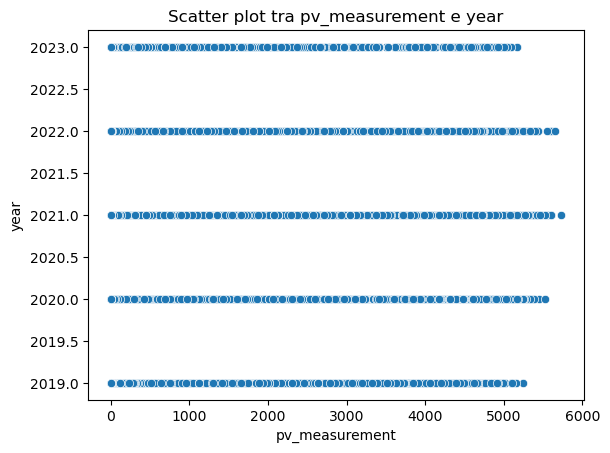

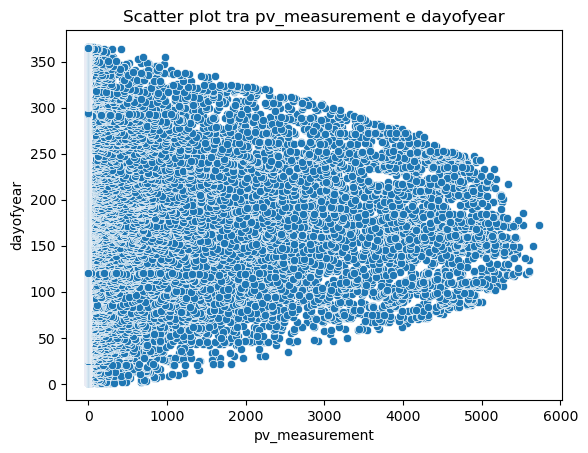

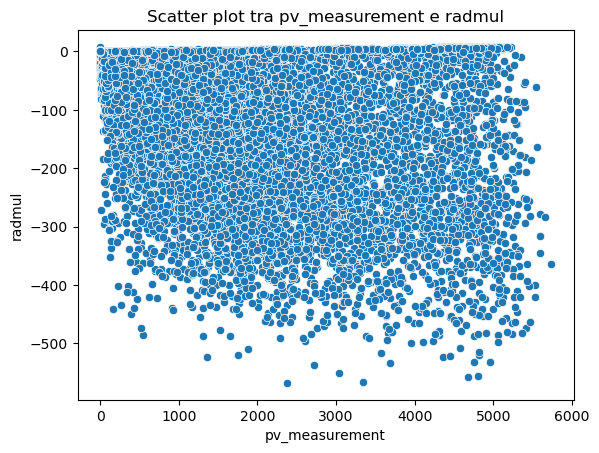

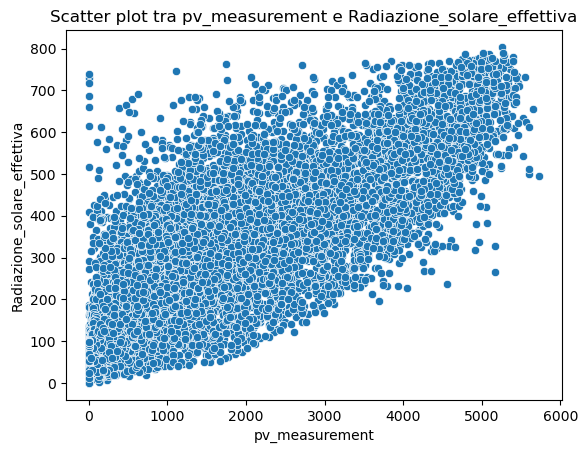

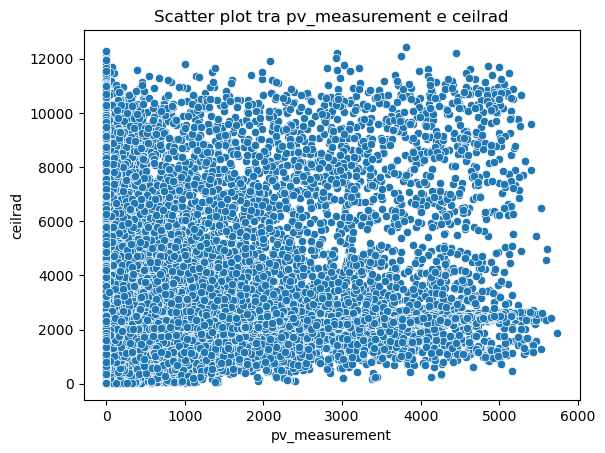

In [302]:
import seaborn as sns

# Itera attraverso tutte le altre feature nel DataFrame standardizzato e crea gli scatter plot
for column in train.columns:
    if column != 'pv_measurement':
        plt.figure()
        sns.scatterplot(data=train, x='pv_measurement', y=column)
        plt.title(f"Scatter plot tra {'pv_measurement'} e {column}")